In [1]:
from pipeline.step_3.build_pipeline import load_and_preprocess as load_and_preprocess_union

In [2]:
from pipeline.step_4.build_pipeline import compose_pipeline
df = compose_pipeline()

[Pipeline] ......... (step 1 of 6) Processing drop_data, total=   0.0s
[Pipeline] . (step 2 of 6) Processing drop_na_base_data, total=   0.0s
[Pipeline] . (step 3 of 6) Processing drop_fill_na_data, total=   0.1s
[Pipeline]  (step 4 of 6) Processing drop_non_informative_data, total=   0.1s
[Pipeline]  (step 5 of 6) Processing join_non_informative_data, total=   0.0s
[Pipeline] . (step 6 of 6) Processing group_by_day_data, total=   5.2s


In [3]:
import numpy as np
import pandas as pd
import imp
from models import model as model_py
from pipeline.step_2 import build_pipeline as build_pipeline_meta


def make_predictions(df):
    df = df[df.index <= df.index[-1] - pd.Timedelta(16, "d")]

    load_and_preprocess_meta = build_pipeline_meta.load_and_preprocess
    df_meta = load_and_preprocess_meta()

    model = model_py.Model()
    shop_id = df.shop_id[0]
    offer_ids = df.groupby('offer_id')['TARGET'].sum(
    ).sort_values(ascending=False)[:10].index

    counter = 0
    for offer_id in offer_ids:
        if counter == 4:
            break
        counter += 1

        df_run = df.loc[(df.shop_id == shop_id) & (df.offer_id == offer_id)]
        df_run.drop(['shop_id', 'offer_id', 'title', 'warehouse_name',
                    'delivery_schema'], axis=1, inplace=True)

        price = df_run['marketing_seller_price']
        cols_to_drop = set(df.columns[df[df_run > 0].sum() == 0]) - set(['shop_id', 'offer_id', 'title', 'warehouse_name',
                                                                        'delivery_schema'])

        df_run.drop(cols_to_drop, axis=1, inplace=True)
        df_run['marketing_seller_price'] = price

        model = model_py.Model()
        model.main(inference=False, df=df_run)

        df_meta_run = df_meta.loc[(df_meta.shop_id == shop_id) & (
            df_meta.offer_id == offer_id)]

        prices = [df_meta_run.index[0], df_meta_run.index[-1]]
        for price in prices:
            df_run['marketing_seller_price'] = [price] * df_run.shape[0]
            model.main(inference=True, df=df_run)

Index(['offer_id', 'marketing_seller_price', 'shop_id', 'min_price',
       'max_price'],
      dtype='object')


100%|██████████| 7/7 [00:00<00:00,  9.77it/s]


<Figure size 960x720 with 0 Axes>

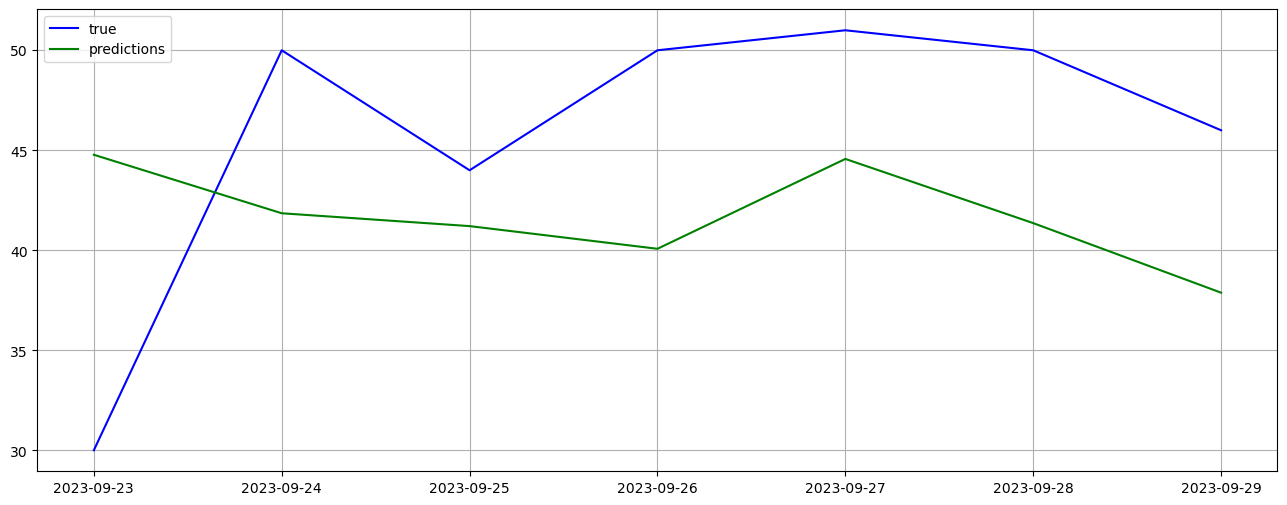

,MAE,RMSE,MAPE,R2
0,8.41,9.05,0.198992,-0.721542


<Figure size 960x720 with 0 Axes>

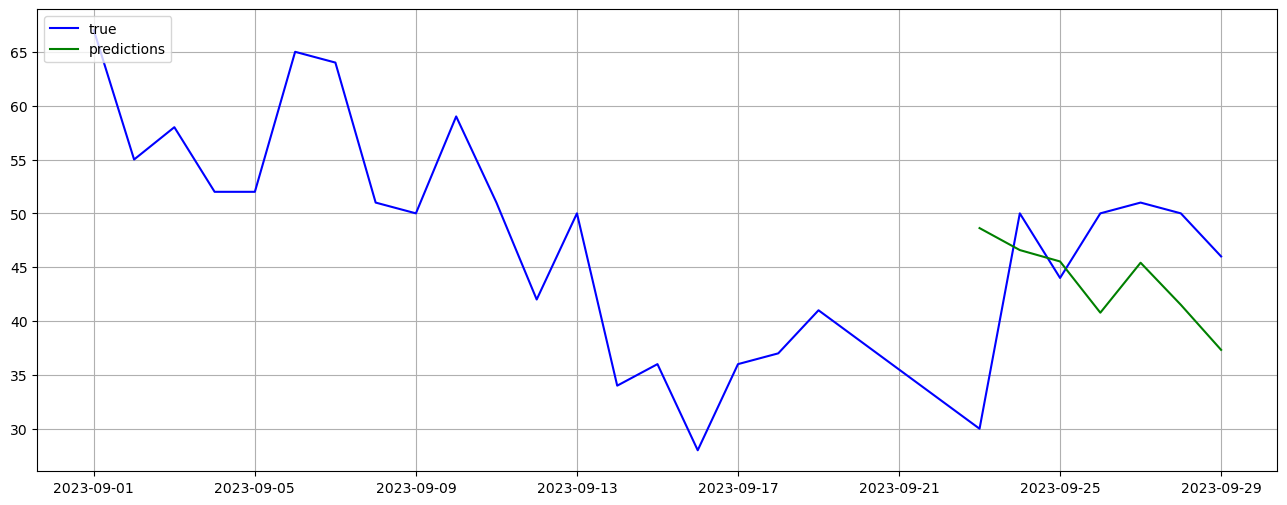

<Figure size 960x720 with 0 Axes>

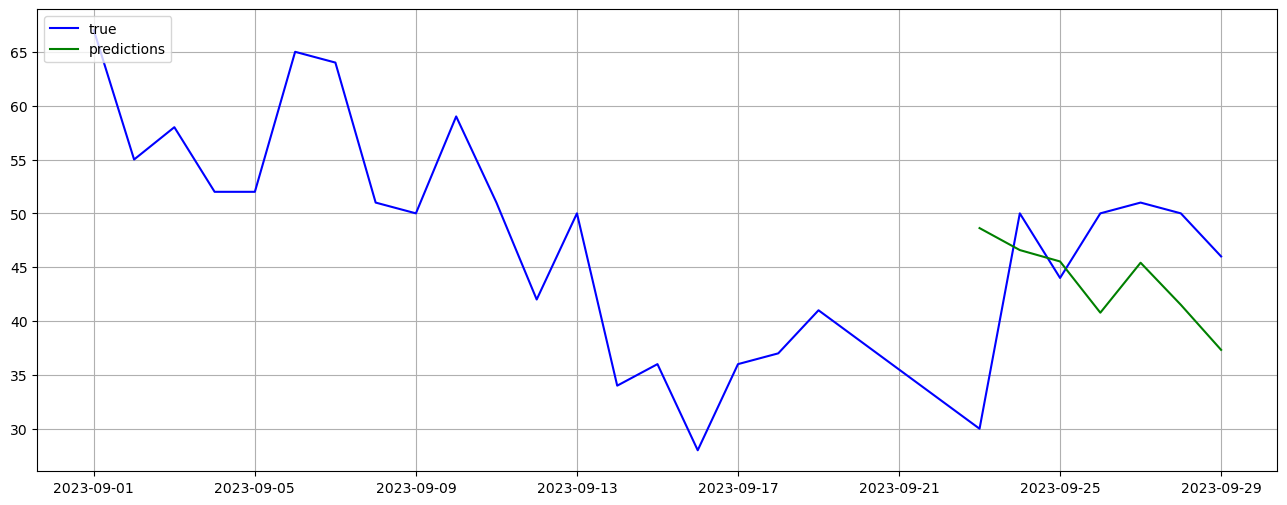

100%|██████████| 7/7 [00:00<00:00, 10.52it/s]


<Figure size 960x720 with 0 Axes>

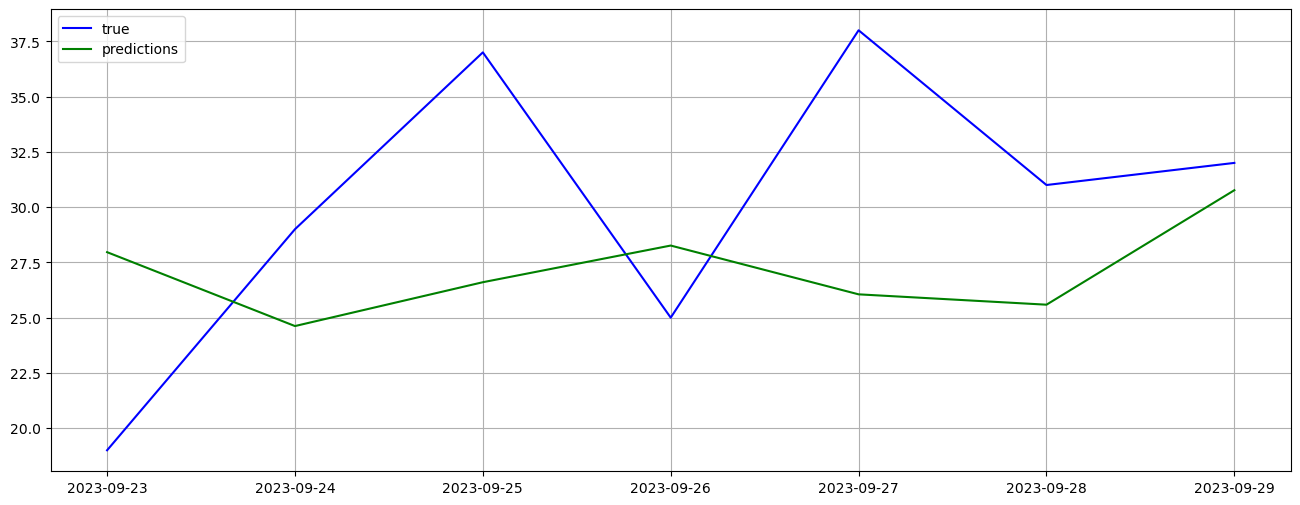

,MAE,RMSE,MAPE,R2
0,6.51,7.48,0.223117,-0.47923


<Figure size 960x720 with 0 Axes>

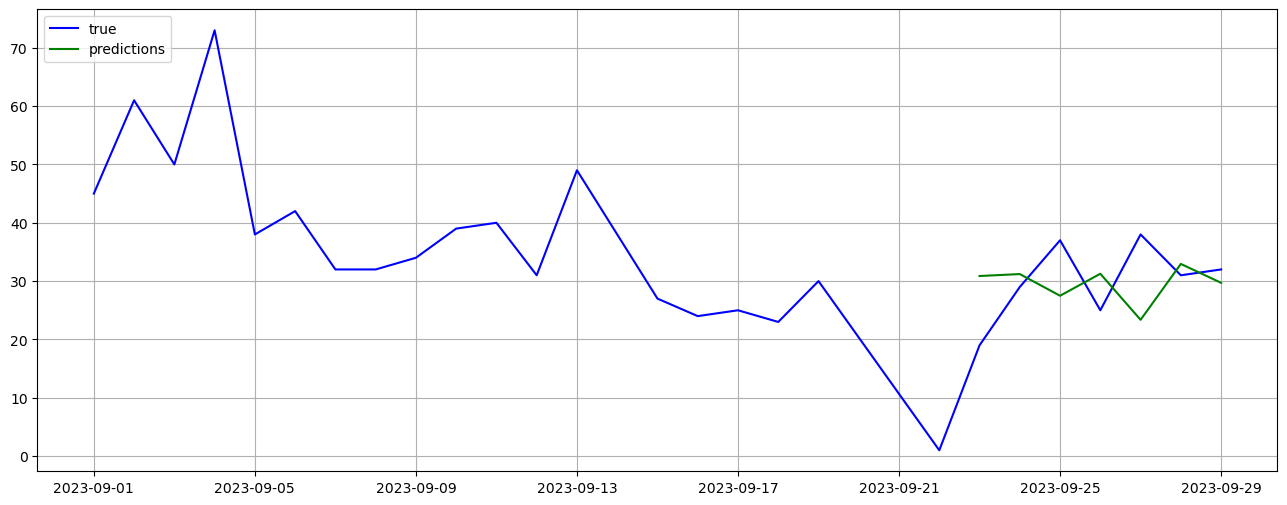

<Figure size 960x720 with 0 Axes>

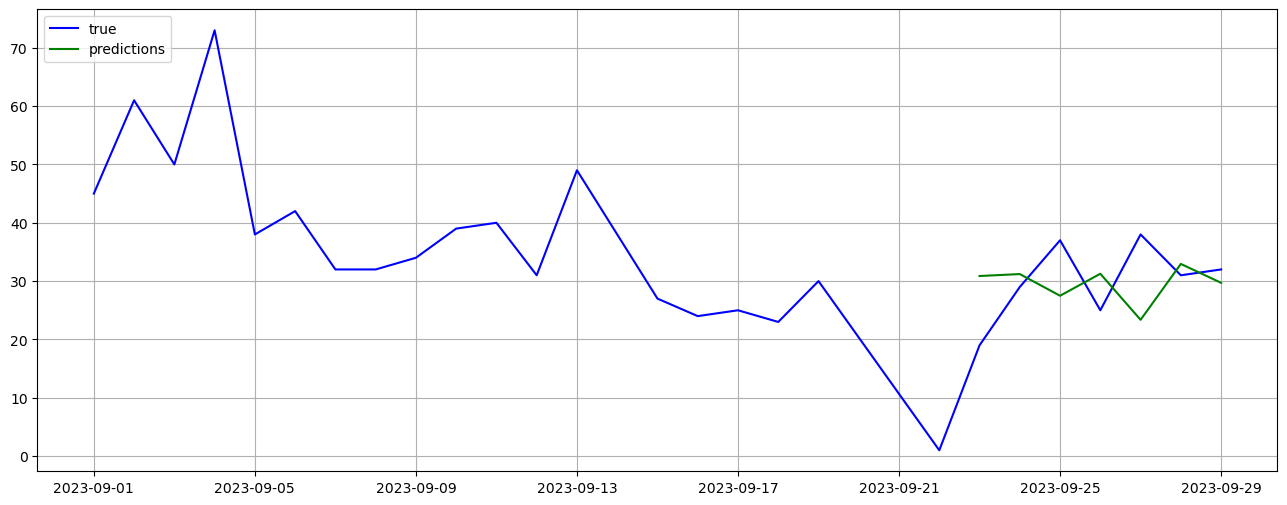

100%|██████████| 7/7 [00:00<00:00,  9.02it/s]


<Figure size 960x720 with 0 Axes>

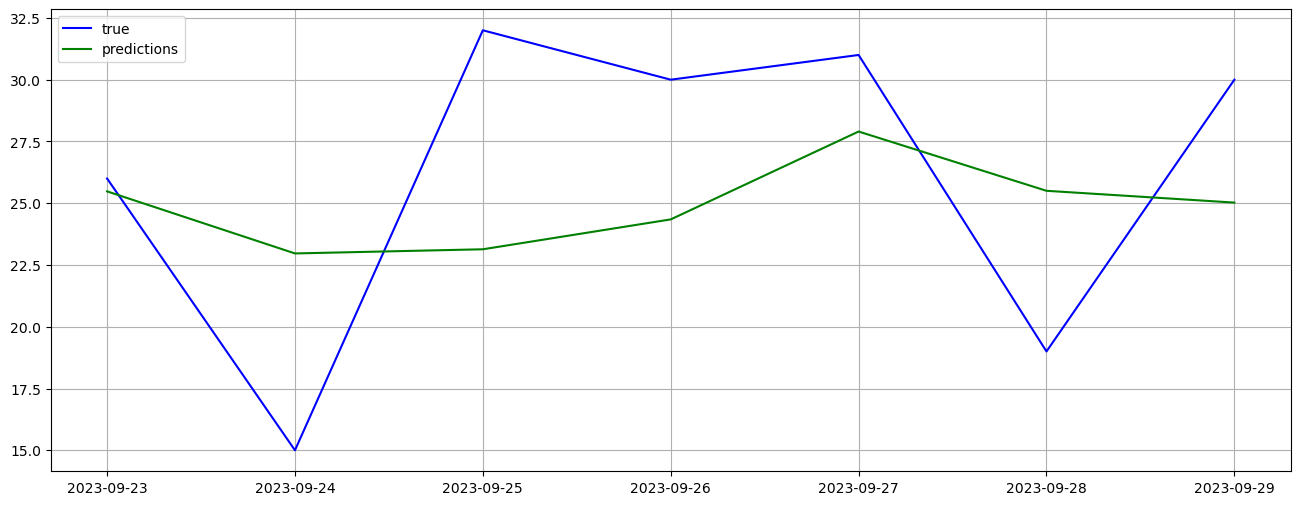

,MAE,RMSE,MAPE,R2
0,5.37,5.99,0.232095,0.045364


<Figure size 960x720 with 0 Axes>

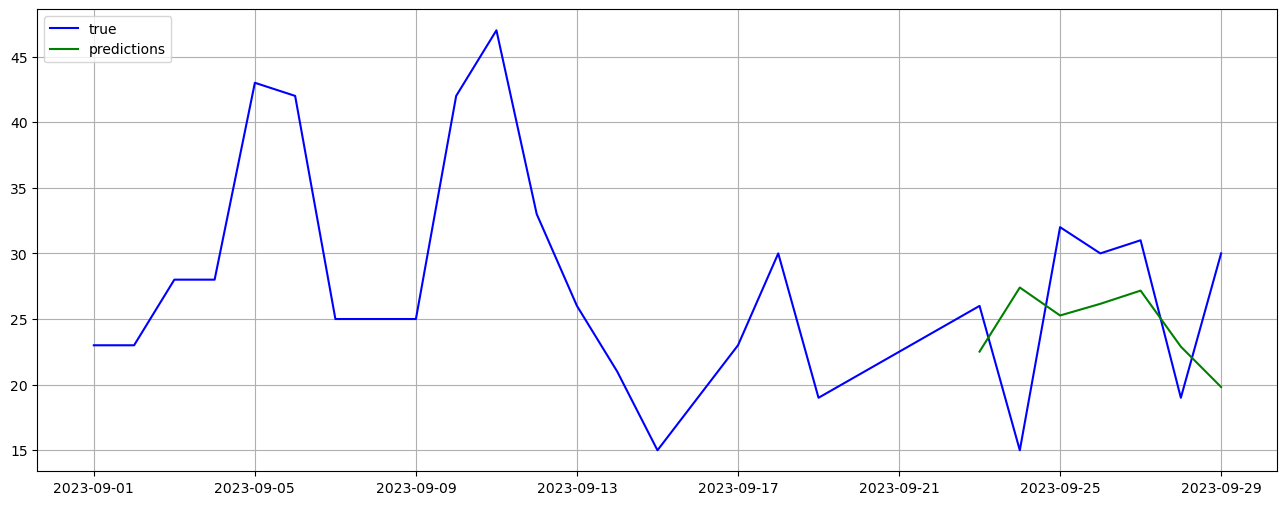

<Figure size 960x720 with 0 Axes>

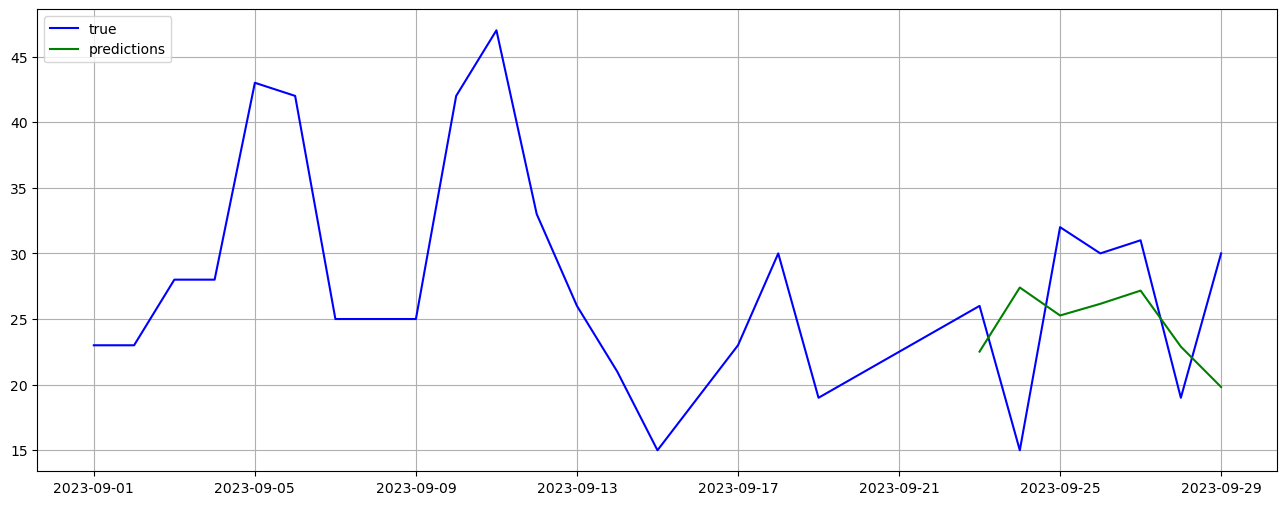

100%|██████████| 7/7 [00:00<00:00,  9.08it/s]


<Figure size 960x720 with 0 Axes>

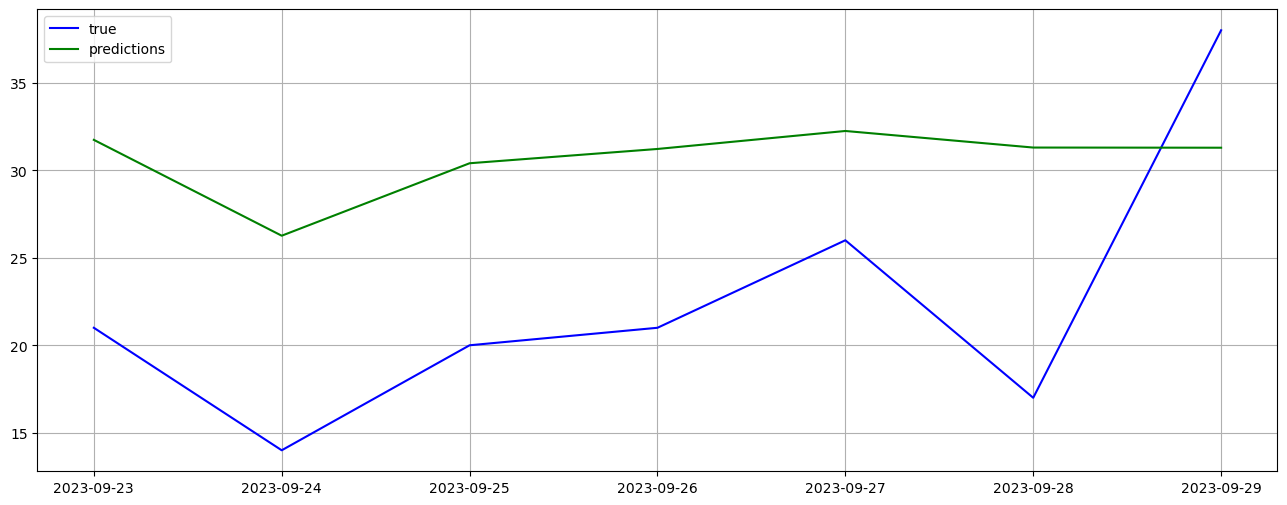

,MAE,RMSE,MAPE,R2
0,10.12,10.47,0.521669,-1.09653


<Figure size 960x720 with 0 Axes>

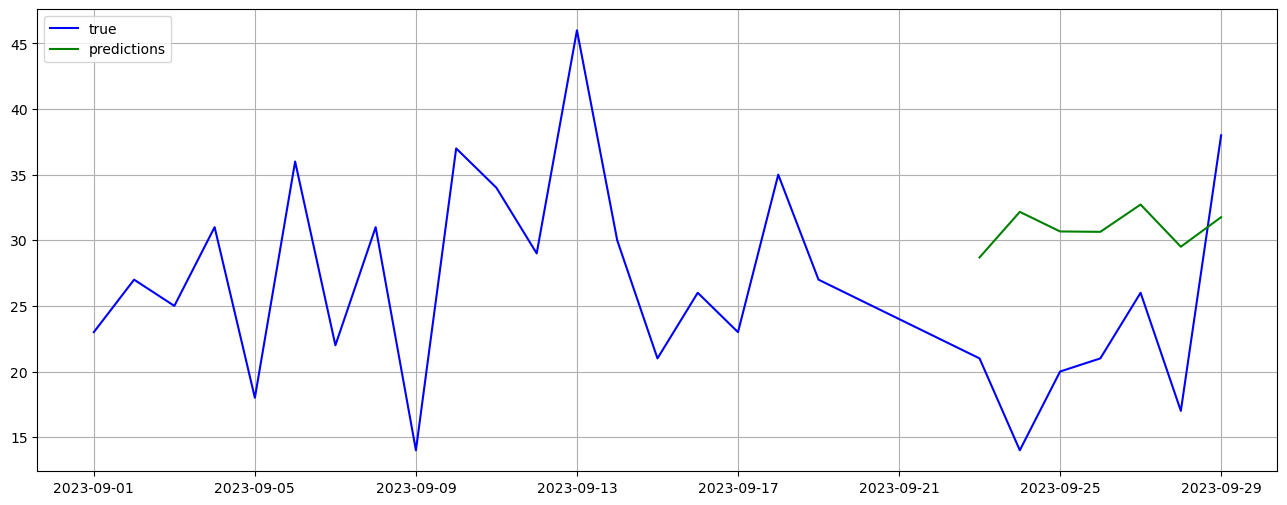

<Figure size 960x720 with 0 Axes>

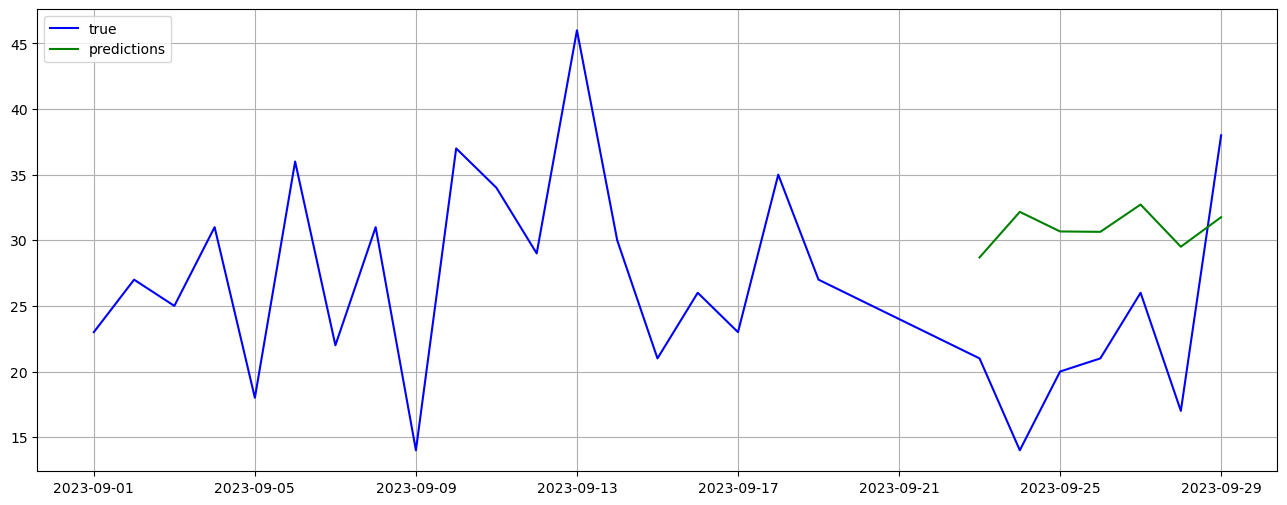

In [4]:
make_predictions(df)